# Tracking COVID-19 Vaccine Distribution Allocations by Jurisdiction

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_latimes as lat
from fbprophet import Prophet
import glob
import os

In [3]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### Where are the allotment data tables held? 

In [4]:
# https://www.hhs.gov/coronavirus/covid-19-vaccines/distribution/index.html#allocation

In [5]:
urls = [
    {
        "url": "https://data.cdc.gov/api/views/saz5-9hgg/rows.csv?accessType=DOWNLOAD",
        "company": "pfizer",
    },
    {
        "url": "https://data.cdc.gov/api/views/b7pe-5nws/rows.csv?accessType=DOWNLOAD",
        "company": "moderna",
    },
    {
        "url": "https://data.cdc.gov/api/views/w9zu-fywh/rows.csv?accessType=DOWNLOAD",
        "company": "janssen",
    },
]

In [6]:
for url in urls:
    !wget {url["url"]} -O 'input/allocations/{url["company"]}.csv'

--2021-03-09 17:21:50--  https://data.cdc.gov/api/views/saz5-9hgg/rows.csv?accessType=DOWNLOAD
Resolving data.cdc.gov (data.cdc.gov)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cdc.gov (data.cdc.gov)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘input/allocations/pfizer.csv’

input/allocations/p     [ <=>                ]  28.01K  --.-KB/s    in 0.008s  

2021-03-09 17:21:51 (3.64 MB/s) - ‘input/allocations/pfizer.csv’ saved [28679]

--2021-03-09 17:21:51--  https://data.cdc.gov/api/views/b7pe-5nws/rows.csv?accessType=DOWNLOAD
Resolving data.cdc.gov (data.cdc.gov)... 52.206.68.26, 52.206.140.205, 52.206.140.199
Connecting to data.cdc.gov (data.cdc.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘input/allocations/moderna.csv’

input/allocations/m     [ <=>                ]  26.09K  --.-KB/s    in 0.001s  

202

In [7]:
path = ""
all_files = glob.glob(os.path.join(path, "input/allocations/*.csv"))

In [8]:
file_df = (
    pd.read_csv(f, encoding="ISO-8859-1", low_memory=False).assign(
        company=os.path.basename(f)
    )
    for f in all_files
)

In [9]:
concatenated_df = pd.concat(file_df, ignore_index=True)

In [10]:
concatenated_df["company"] = concatenated_df["company"].str.replace(
    ".csv", "", regex=False
)

In [11]:
concatenated_df = concatenated_df.fillna(0)

In [12]:
concatenated_df.rename(
    columns={
        "Jurisdiction": "place",
        "Week of Allocations": "ds",
        "1st Dose Allocations": "first",
        "2nd Dose Allocations": "second",
    },
    inplace=True,
)

---

### Total allocations per week

In [13]:
weekly = concatenated_df.groupby("ds").agg({"first": sum, "second": sum}).reset_index()

In [14]:
weekly["ds"] = pd.to_datetime(weekly["ds"])

In [15]:
weekly = weekly.sort_values("ds", ascending=True)

In [16]:
weekly = weekly[weekly["ds"] > "2021-01-01"]

In [17]:
weekly["total"] = weekly["first"] + weekly["second"]

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [18]:
weekly["y"] = weekly["total"]

In [19]:
weekly["cumsum"] = weekly["total"].cumsum()

In [20]:
weekly_slim = weekly[["ds", "y"]]

In [21]:
weekly_slim.tail()

,ds,y
6,2021-02-15,10999750.0
7,2021-02-22,13500040.0
8,2021-03-01,17673560.0
9,2021-03-08,15298380.0
10,2021-03-15,15724160.0


In [22]:
m = Prophet()
m.fit(weekly)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [23]:
future = m.make_future_dataframe(periods=100)
future.tail()

,ds
106,2021-06-19
107,2021-06-20
108,2021-06-21
109,2021-06-22
110,2021-06-23


In [24]:
forecast = m.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
106,2021-06-19,2.913279e+07,2.762354e+07,3.075584e+07
107,2021-06-20,2.926609e+07,2.768575e+07,3.088419e+07
108,2021-06-21,2.939939e+07,2.788447e+07,3.093424e+07
109,2021-06-22,2.953269e+07,2.791242e+07,3.105784e+07
110,2021-06-23,2.966599e+07,2.806577e+07,3.128778e+07


In [25]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
106,2021-06-19,2.913279e+07,2.762354e+07,3.075584e+07,2.913279e+07,2.913279e+07,0.0,0.0,0.0,0.0,0.0,0.0,2.913279e+07
107,2021-06-20,2.926609e+07,2.768575e+07,3.088419e+07,2.926609e+07,2.926609e+07,0.0,0.0,0.0,0.0,0.0,0.0,2.926609e+07
108,2021-06-21,2.939939e+07,2.788447e+07,3.093424e+07,2.939939e+07,2.939939e+07,0.0,0.0,0.0,0.0,0.0,0.0,2.939939e+07
109,2021-06-22,2.953269e+07,2.791242e+07,3.105784e+07,2.953269e+07,2.953269e+07,0.0,0.0,0.0,0.0,0.0,0.0,2.953269e+07
110,2021-06-23,2.966599e+07,2.806577e+07,3.128778e+07,2.966599e+07,2.966599e+07,0.0,0.0,0.0,0.0,0.0,0.0,2.966599e+07


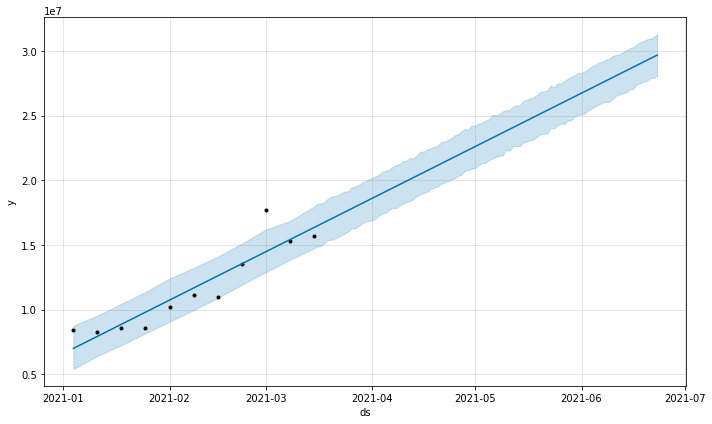

In [26]:
fig1 = m.plot(forecast)